In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import matplotlib.pyplot as plt

In [89]:
from load_results import load_results
from load_results import get_percentage_of_queries_with_correct_results
from load_results import get_percentage_of_examples_with_correct_results
from load_results import get_positions_of_correct_results
from load_results import get_best_position_of_correct_results
from load_results import get_average_position_of_a_correct_results

results = load_results()

# SeaGOAT query accuracy

## % of queries resulting in a correct result

In [90]:
get_percentage_of_queries_with_correct_results(results, "random")

0.966183574879227

In [91]:
get_percentage_of_queries_with_correct_results(results, "seagoat")

41.06280193236715

## % of examples with at least one query resulting in a correct result

In [92]:
get_percentage_of_examples_with_correct_results(results, 'random')

6.779661016949152

In [93]:
get_percentage_of_examples_with_correct_results(results, 'seagoat')

81.35593220338984

## Position of correct result when a correct result is found

(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([ 10.  ,  18.75,  27.5 ,  36.25,  45.  ,  53.75,  62.5 ,  71.25,
         80.  ,  88.75,  97.5 , 106.25, 115.  , 123.75, 132.5 , 141.25,
        150.  , 158.75, 167.5 , 176.25, 185.  ]),
 <BarContainer object of 20 artists>)

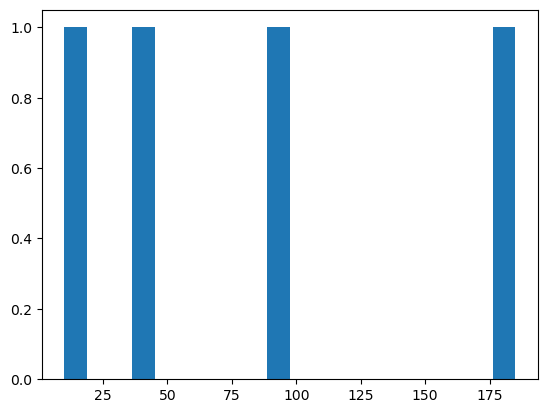

In [94]:
plt.hist(get_positions_of_correct_results(results, 'random'), 20)

(array([33., 64., 15., 16.,  2.,  4.,  2.,  5.,  0., 10.,  0.,  0.,  2.,
         0.,  0.,  7.,  0.,  5.,  0.,  5.]),
 array([  2. ,  11.4,  20.8,  30.2,  39.6,  49. ,  58.4,  67.8,  77.2,
         86.6,  96. , 105.4, 114.8, 124.2, 133.6, 143. , 152.4, 161.8,
        171.2, 180.6, 190. ]),
 <BarContainer object of 20 artists>)

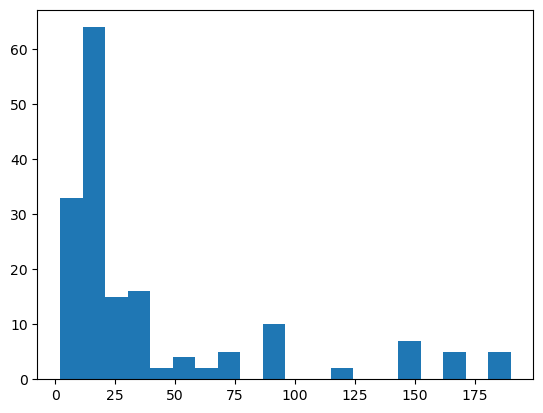

In [95]:
plt.hist(get_positions_of_correct_results(results, 'seagoat'), 20)

## Best result position for examples

(array([ 6., 17.,  7.,  4.,  1.,  2.,  1.,  2.,  0.,  3.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  1.,  0.,  2.]),
 array([  2. ,  11.4,  20.8,  30.2,  39.6,  49. ,  58.4,  67.8,  77.2,
         86.6,  96. , 105.4, 114.8, 124.2, 133.6, 143. , 152.4, 161.8,
        171.2, 180.6, 190. ]),
 <BarContainer object of 20 artists>)

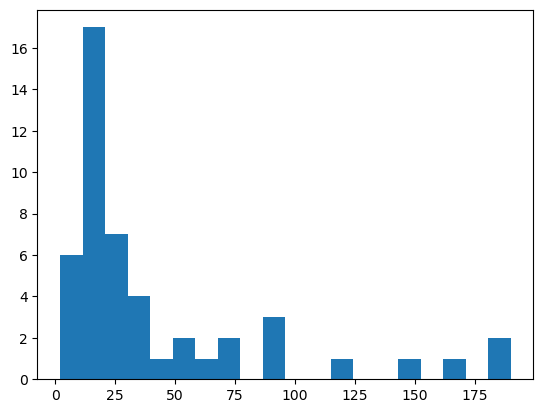

In [96]:
plt.hist(get_best_position_of_correct_results(results, 'seagoat'), 20)

## Average position of correct results

In [97]:
get_average_position_of_a_correct_results(results, 'seagoat')

40.805882352941175